<a href="https://colab.research.google.com/github/troberts60/LRRK2_Drug_Study/blob/main/LRRK2_Lipinski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Conda and rdkit

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-11-29 18:17:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  70.0MB/s    in 1.2s    

2021-11-29 18:17:41 (70.0 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37

#Load Data

In [2]:
import pandas as pd

df = pd.read_csv('lrrk2_preprocessed_data.csv')

#Libraries

In [3]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski 

#Calculate Descripors

In [4]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lip(smiles, verbose=False):
  molData = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    molData.append(mol)
  
  bd = np.arange(1,1)
  i = 0
  for mol in molData:
    desc_MolWt = Descriptors.MolWt(mol)
    desc_LogP = Descriptors.MolLogP(mol)
    desc_Hdonor = Lipinski.NumHDonors(mol)
    desc_HAccep = Lipinski.NumHAcceptors(mol)

    row = np.array([desc_MolWt,
                    desc_LogP,
                    desc_Hdonor,
                    desc_HAccep])
    
    if (i==0):
      bd = row
    else:
      bd = np.vstack([bd,row])
    i= i+1
  colNames = ["MW", "LogP", "hDon", "hAcc"]
  descript = pd.DataFrame(data=bd,columns=colNames)
  return descript

In [5]:
df_lip = lip(df.canonical_smiles)

#Combine Data Frames

In [6]:
df_lip

,MW,LogP,hDon,hAcc
0,293.326,3.40042,3.0,5.0
1,262.316,3.38422,1.0,4.0
2,458.566,3.88950,2.0,6.0
3,570.698,3.43870,1.0,9.0
4,614.216,5.02410,2.0,10.0
...,...,...,...,...
1199,522.509,3.89070,2.0,8.0
1200,482.566,3.73680,2.0,8.0
1201,446.536,3.25380,3.0,8.0
1202,393.491,3.57520,0.0,7.0


In [7]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,13200.0,inactive
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,4100.0,inactive
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,16.0,active
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,13.0,active
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,7.8,active
...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,8894.0,inactive
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,683.0,inactive
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,94.6,active
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,6480.0,inactive


In [8]:
df_comb = pd.concat([df,df_lip],axis=1)

In [9]:
df_comb

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,hDon,hAcc
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,13200.0,inactive,293.326,3.40042,3.0,5.0
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,4100.0,inactive,262.316,3.38422,1.0,4.0
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,16.0,active,458.566,3.88950,2.0,6.0
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,13.0,active,570.698,3.43870,1.0,9.0
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,7.8,active,614.216,5.02410,2.0,10.0
...,...,...,...,...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,8894.0,inactive,522.509,3.89070,2.0,8.0
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,683.0,inactive,482.566,3.73680,2.0,8.0
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,94.6,active,446.536,3.25380,3.0,8.0
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,6480.0,inactive,393.491,3.57520,0.0,7.0


#Convert IC50 to pIC50
This transformation is done to reduce variablility in the standard value.

In [11]:
import numpy as np

def pIC50(input):
  p50 = []
  for i in input['standard_value']:
    molar = i*(10**-9)
    p50.append(-np.log10(molar))

  input['pIC50'] = p50
  new_df = input.drop('standard_value',axis=1)

  return new_df 


In [12]:
df_new = pIC50(df_comb)

In [ ]:
df_new

,molecule_chembl_id,canonical_smiles,class,MW,LogP,hDon,hAcc,pIC50
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,inactive,293.326,3.40042,3.0,5.0,4.879426
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,inactive,262.316,3.38422,1.0,4.0,5.387216
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,active,458.566,3.88950,2.0,6.0,7.795880
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,active,570.698,3.43870,1.0,9.0,7.886057
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,active,614.216,5.02410,2.0,10.0,8.107905
...,...,...,...,...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,522.509,3.89070,2.0,8.0,5.050903
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,482.566,3.73680,2.0,8.0,6.165579
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,active,446.536,3.25380,3.0,8.0,7.024109
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,inactive,393.491,3.57520,0.0,7.0,5.188425


In [15]:
df_new.to_csv('lrrk2_ml_data.csv', index=False)

In [16]:
df_final = df_new

In [17]:
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,hDon,hAcc,pIC50
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,inactive,293.326,3.40042,3.0,5.0,4.879426
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,inactive,262.316,3.38422,1.0,4.0,5.387216
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,active,458.566,3.88950,2.0,6.0,7.795880
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,active,570.698,3.43870,1.0,9.0,7.886057
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,active,614.216,5.02410,2.0,10.0,8.107905
...,...,...,...,...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,522.509,3.89070,2.0,8.0,5.050903
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,482.566,3.73680,2.0,8.0,6.165579
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,active,446.536,3.25380,3.0,8.0,7.024109
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,inactive,393.491,3.57520,0.0,7.0,5.188425


In [ ]:
df_final.pIC50.describe()

count    1204.000000
mean        7.206536
std         1.025880
min         3.995335
25%         6.555955
50%         7.366532
75%         7.955660
max        12.000000
Name: pIC50, dtype: float64

#Remove Intermediate 
This project is only going to take into account active and inactive drugs

In [18]:
df_final.rename(columns={'class':'bio_class'}, inplace=True)
df_final

,molecule_chembl_id,canonical_smiles,bio_class,MW,LogP,hDon,hAcc,pIC50
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,inactive,293.326,3.40042,3.0,5.0,4.879426
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,inactive,262.316,3.38422,1.0,4.0,5.387216
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,active,458.566,3.88950,2.0,6.0,7.795880
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,active,570.698,3.43870,1.0,9.0,7.886057
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,active,614.216,5.02410,2.0,10.0,8.107905
...,...,...,...,...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,522.509,3.89070,2.0,8.0,5.050903
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,482.566,3.73680,2.0,8.0,6.165579
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,active,446.536,3.25380,3.0,8.0,7.024109
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,inactive,393.491,3.57520,0.0,7.0,5.188425


In [19]:
df_ai = df_final[df_final.bio_class != 'intermediate']

In [20]:
df_ai

,molecule_chembl_id,canonical_smiles,bio_class,MW,LogP,hDon,hAcc,pIC50
0,CHEMBL1771409,Cc1cc(N/N=C/c2ccc(O)c(O)c2)nc2ccccc12,inactive,293.326,3.40042,3.0,5.0,4.879426
1,CHEMBL1771411,Cc1cc(N/N=C/c2ccncc2)nc2ccccc12,inactive,262.316,3.38422,1.0,4.0,5.387216
2,CHEMBL1933288,C[C@@H]1CCNC(=O)c2cc3ccc(C(=O)Nc4nc5ccccc5n4CC...,active,458.566,3.88950,2.0,6.0,7.795880
3,CHEMBL2012582,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,active,570.698,3.43870,1.0,9.0,7.886057
4,CHEMBL509032,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,active,614.216,5.02410,2.0,10.0,8.107905
...,...,...,...,...,...,...,...,...
1199,CHEMBL4641263,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,522.509,3.89070,2.0,8.0,5.050903
1200,CHEMBL4635720,COc1cc(NS(C)(=O)=O)ccc1Nc1ncc2c(n1)N(C)c1ccccc...,inactive,482.566,3.73680,2.0,8.0,6.165579
1201,CHEMBL4645565,CC(O)(C#Cc1ccc(N2CCOCC2)c(Nc2ncnc3[nH]ccc23)c1...,active,446.536,3.25380,3.0,8.0,7.024109
1202,CHEMBL4560589,C[C@H]1CN(c2cc(-c3nn(C)c4ccc(OC5(C)CC5)cc34)nc...,inactive,393.491,3.57520,0.0,7.0,5.188425


In [22]:
df_ai.to_csv('lrrk2_stat_data.csv', index=False)

#Import Library

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

##Frequency of active and inactive

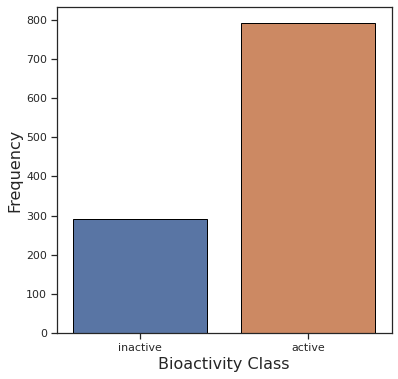

In [ ]:
plt.figure(figsize=(6.0,6.0))

sns.countplot(x='bio_class', data=df_ai, edgecolor='black')

plt.xlabel("Bioactivity Class",fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.savefig('bioactivity_plot.pdf')

##BoxPlot for MW

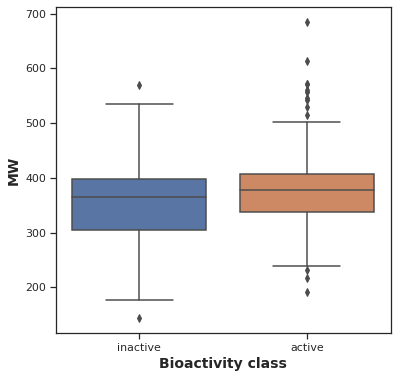

In [ ]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'bio_class', y = 'MW', data = df_ai)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

##Boxplot for LogP

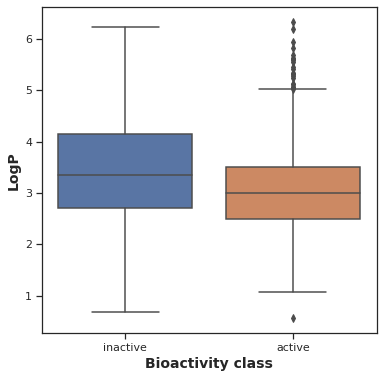

In [ ]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'bio_class', y = 'LogP', data = df_ai)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

##Boxplot for hDon

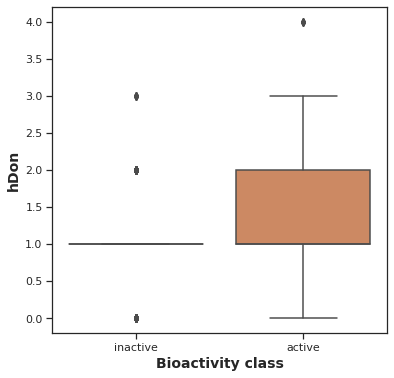

In [ ]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'bio_class', y = 'hDon', data = df_ai)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('hDon', fontsize=14, fontweight='bold')

plt.savefig('plot_hDon.pdf')

##Boxplot for hAcc

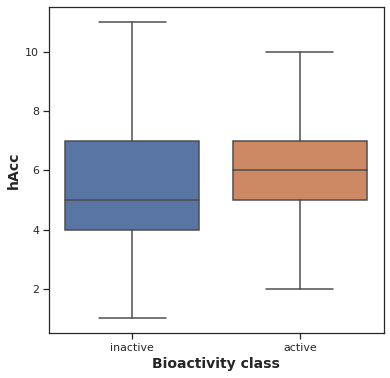

In [ ]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'bio_class', y = 'hAcc', data = df_ai)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('hAcc', fontsize=14, fontweight='bold')

plt.savefig('plot_hAcc.pdf')

##Boxplot pCI50

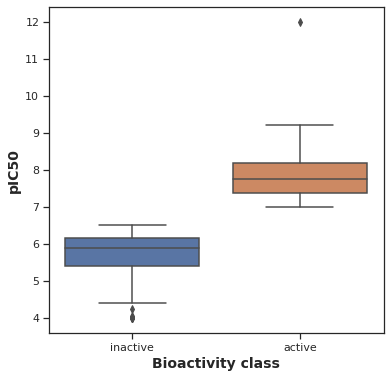

In [ ]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'bio_class', y = 'pIC50', data = df_ai)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')

plt.savefig('plot_pIC50.pdf')

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_hAcc.pdf (deflated 38%)
  adding: mannwhitneyu_hDon.csv (deflated 10%)
  adding: lrrk2_bio_pre-processed.csv (deflated 80%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 38%)
  adding: bioactivity_plot.pdf (deflated 33%)
  adding: mannwhitneyu_MW.csv (deflated 7%)
  adding: plot_pIC50.pdf (deflated 37%)
  adding: mannwhitneyu_hAcc.csv (deflated 8%)
  adding: lrrk2_preprocessed_data.csv (deflated 82%)
  adding: plot_hDon.pdf (deflated 39%)
  adding: mannwhitneyu_LogP.csv (deflated 6%)
